## AutoPark - Number Plate Detection and Recognition
---
42028 - Assignment 3 - By PlateMates (Group 6)

The dataset used can be found here: https://github.com/detectRecog/CCPD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/DL-CNN-A3

# !tar xvzf dataset/CCPD_2019_datasets.tar.gz

/content/drive/My Drive/DL-CNN-A3


#### Import necessary modules

In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras

# import the pre-trained CNN and its related preprocessing method
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.models import Model

## Dataset Annotations

Annotations are embedded in the file name.

A sample image name is "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg". Each name can be split into seven fields. Those fields are explained as follows.

- **Area**: Area ratio of license plate area to the entire picture area.

- **Tilt degree**: Horizontal tilt degree and vertical tilt degree.

- **Bounding box coordinates**: The coordinates of the left-up and the right-bottom vertices.

- **Four vertices locations**: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

- **License plate number**: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters). "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.
```
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
```

- **Brightness**: The brightness of the license plate region.

- **Blurriness**: The Blurriness of the license plate region.

In [0]:
def load_dataset(directory, target_size):
    """Loads and preprocesses images from given directory"""
    files = sorted(os.listdir(directory))

    images = []
    boxes = []
    plate_labels = []

    for filename in files:
        # get bounding box coords and plate number
        f = filename.split("-")
        bounding_box = [int(e) for e in f[2].split("_") for e in e.split("&")] # gives [xmin, ymin, xmax, ymax]
        plate_number = [int(e) for e in f[4].split("_")]

        # extract image data to numpy array
        image_path = os.path.join(directory, filename)
        img = image.load_img(image_path, target_size=target_size)
        img_arr = image.img_to_array(img)
        img_arr = preprocess_input(img_arr) # Xception preprocessing

        # scale bounding box to new ratio and normalise
        x_scale = target_size[0] / 720 # TODO remove hardcoding for original width/height
        y_scale = target_size[0] / 1160
        bounding_box = np.round([
            e * x_scale if (i % 2 == 0) else 
            e * y_scale for i, e in enumerate(bounding_box)]) / target_size[0] # normalise bounding boxes
        
        images.append(img_arr)
        boxes.append(bounding_box)
        plate_labels.append(plate_number)
    
    return np.array(images), np.array(boxes), np.array(plate_labels)

In [5]:
# dataset directories
base_dir = "dataset/"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validation")

target_size = (512, 512)

# load data for each set
X_train, y_train_boxes, y_train_labels = load_dataset(train_dir, target_size)
X_test, y_test_boxes, y_test_labels  = load_dataset(test_dir, target_size)
X_val, y_val_boxes, y_val_labels  = load_dataset(val_dir, target_size)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))
print("Validation samples:", len(X_val))

Train samples: 700
Test samples: 150
Validation samples: 150


### Utility functions

In [0]:
# source: http://ronny.rest/tutorials/module/localization_001/iou/

def get_iou(a, b):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    epsilon = keras.backend.epsilon()
    
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    
    return iou

def mean_iou(a, b):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the mean of the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates

    Returns:
        (float) The mean of the Intersect of Union scores for each pair of bounding
        boxes.
    """
    epsilon = keras.backend.epsilon()
    
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = keras.backend.max([a[:, 0], b[:, 0]], axis=0)
    y1 = keras.backend.max([a[:, 1], b[:, 1]], axis=0)
    x2 = keras.backend.min([a[:, 2], b[:, 2]], axis=0)
    y2 = keras.backend.min([a[:, 3], b[:, 3]], axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width = keras.backend.maximum(width, 0)
    height = keras.backend.maximum(height, 0)

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    
    # Mean IoU 
    iou_mean = keras.backend.mean(iou)
    
    return iou_mean

In [0]:
def get_bbox(boxes, scale=target_size[0]):
    """Returns de-normalised bounding boxes"""
    return boxes * scale

### Sample images from the dataset

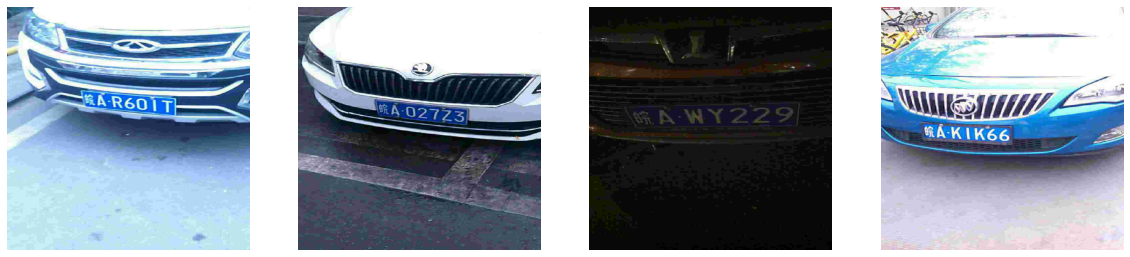

Image indices: [277, 247, 541, 212]


In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10))
plot_indices = []

for ax in axes:
    i = np.random.randint(len(X_train)) # display random images
    plot_indices.append(i)
    img = image.array_to_img(X_train[i])

    ax.imshow(img)
    ax.axis("off")

plt.show()
print("Image indices:", plot_indices)

## Build the model  
Uses Xception with imagenet weights as the base model

In [0]:
keras.backend.clear_session() # clear previous models from memory

input_shape = (512, 512, 3)

In [0]:
def make_model():
    # create new model
    base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape)

    # start from block13_sepconv2_activation to begin with 32x32 dimensionality
    x = base_model.layers[-13].output

    # add dropout2d layer to improve regularisation
    x = SpatialDropout2D(0.3)(x)
    
    # add additional conv2d layers to reduce dimensionality down to 1x1
    x = Conv2D(1024, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(1024, (1, 1), activation="relu")(x)

    x = Conv2D(256, (1, 1), activation="relu", padding="same")(x)
    x = Conv2D(512, (3, 3), strides=(2, 2), activation="relu")(x)

    x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

    x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

    x = Conv2D(128, (1, 1), activation="relu", padding="same")(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), activation="relu")(x)

    # FC layers and 4 neuron output layer for bounding box coordinates
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)

    x = Dense(4, activation=None)(x)

    # this is the model to be trained
    model = Model(inputs=base_model.input, outputs=x)

    # freeze the base_model layers
    for layer in base_model.layers[:-13]:
        layer.trainable = False

    # compile model
    model.compile(optimizer="adam", loss="huber_loss", metrics=[mean_iou])
    
    return model

def make_or_restore_model(force_make=False):
    # restore latest model or create a new one if one isn't available
    if not os.path.isdir("checkpoints"):
        os.mkdir("checkpoints")
    
    checkpoints = ["checkpoints/" + file for file in os.listdir("checkpoints/")]
    
    if checkpoints and not force_make:
        chk_latest = max(checkpoints, key=os.path.getctime)
        print("Using", chk_latest)
        return keras.models.load_model(chk_latest, custom_objects={'mean_iou': mean_iou})
    
    print("Creating new model")
    return make_model()

In [11]:
# create or restore model
model = make_or_restore_model(force_make=True)

Creating new model
83689472/83683744 [==============================] - 2s 0us/step


In [0]:
# setup callbacks to use during training
chk_path = os.path.join("checkpoints/", "model.{epoch:02d}-mIoU{val_mean_iou:.4f}.h5")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=chk_path,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=False,
    save_best_only=True,
    verbose=1)

stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_mean_iou",
    mode="max",
    min_delta=0.01,
    patience=16,
    verbose=1,
    restore_best_weights=True)

my_callbacks = [
    checkpoint_callback,
    stopping_callback
    # keras.callbacks.ReduceLROnPlateau(patience=4)
]

In [13]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Train the model

In [14]:
eps = 100
b_size = 32

# train model
history = model.fit(X_train, y_train_boxes, batch_size=b_size, epochs=eps, verbose=2,
                    validation_data=(X_val, y_val_boxes), callbacks=my_callbacks)

Epoch 1/100

Epoch 00001: val_mean_iou improved from -inf to 0.00000, saving model to checkpoints/model.01-mIoU0.0000.h5
22/22 - 54s - loss: 0.7269 - mean_iou: 0.0204 - val_loss: 0.0610 - val_mean_iou: 0.0000e+00
Epoch 2/100

Epoch 00002: val_mean_iou improved from 0.00000 to 0.00176, saving model to checkpoints/model.02-mIoU0.0018.h5
22/22 - 45s - loss: 0.0146 - mean_iou: 0.1282 - val_loss: 0.0053 - val_mean_iou: 0.0018
Epoch 3/100

Epoch 00003: val_mean_iou improved from 0.00176 to 0.44186, saving model to checkpoints/model.03-mIoU0.4419.h5
22/22 - 46s - loss: 0.0037 - mean_iou: 0.3446 - val_loss: 0.0031 - val_mean_iou: 0.4419
Epoch 4/100

Epoch 00004: val_mean_iou improved from 0.44186 to 0.45276, saving model to checkpoints/model.04-mIoU0.4528.h5
22/22 - 46s - loss: 0.0032 - mean_iou: 0.3974 - val_loss: 0.0030 - val_mean_iou: 0.4528
Epoch 5/100

Epoch 00005: val_mean_iou did not improve from 0.45276
22/22 - 45s - loss: 0.0031 - mean_iou: 0.4068 - val_loss: 0.0031 - val_mean_iou: 0.

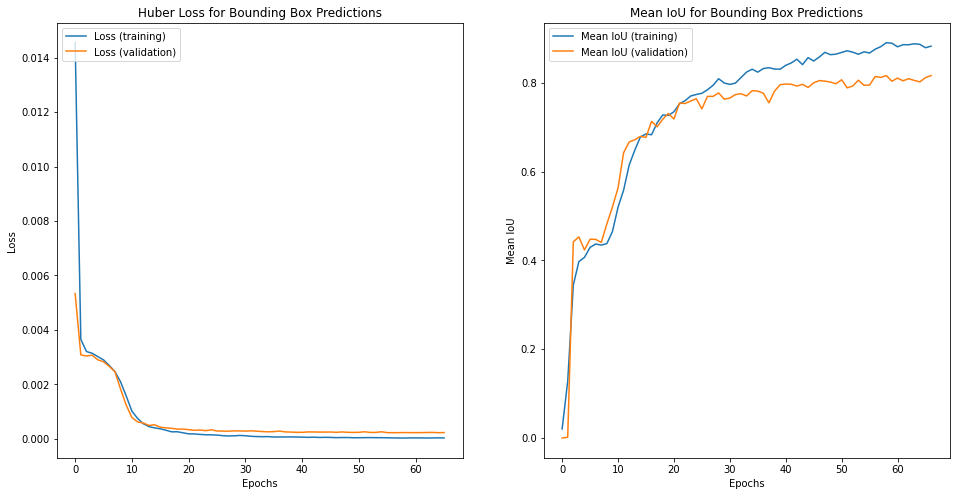

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot loss
ax[0].plot(history.history["loss"][1:], label="Loss (training)")
ax[0].plot(history.history["val_loss"][1:], label="Loss (validation)")
ax[0].set_title("Huber Loss for Bounding Box Predictions")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend(loc="upper left")

# plot mean iou
ax[1].plot(history.history["mean_iou"], label="Mean IoU (training)")
ax[1].plot(history.history["val_mean_iou"], label="Mean IoU (validation)")
ax[1].set_title("Mean IoU for Bounding Box Predictions")
ax[1].set_ylabel("Mean IoU")
ax[1].set_xlabel("Epochs")
ax[1].legend(loc="upper left")

plt.show()

In [0]:
# make predictions on bounding box locations
y_preds = model.predict(X_test)

In [17]:
print(model.evaluate(X_test, y_test_boxes))

5/5 [==============================] - 6s 1s/step - loss: 2.0966e-04 - mean_iou: 0.7970
[0.00020966152078472078, 0.7969802021980286]


In [21]:
si = 90 # starting index
num_samples = 16 # number of samples to show (prefer multiples of 4)

y_tr = np.array([get_bbox(e) for e in y_test_boxes[si:si + num_samples]])
y_pr = np.round([get_bbox(e) for e in y_preds[si:si + num_samples]])

print("     Ground Truth \t    Predictions")
for arr_true, arr_pred in zip(y_tr, y_pr):
    print(arr_true, arr_pred)

     Ground Truth 	    Predictions
[102. 214. 374. 283.] [108. 213. 372. 282.]
[ 92. 218. 371. 286.] [110. 221. 370. 284.]
[126. 204. 388. 277.] [128. 203. 387. 278.]
[102. 197. 363. 271.] [109. 197. 356. 271.]
[117. 177. 338. 265.] [122. 173. 342. 256.]
[154. 198. 437. 268.] [154. 199. 440. 266.]
[ 96. 200. 431. 259.] [ 95. 191. 443. 261.]
[154. 171. 357. 269.] [154. 168. 354. 269.]
[107. 190. 381. 263.] [114. 199. 379. 262.]
[183. 107. 447. 184.] [177. 118. 430. 195.]
[130. 147. 380. 227.] [131. 150. 387. 230.]
[105. 190. 398. 260.] [101. 190. 394. 258.]
[119. 182. 356. 271.] [112. 182. 351. 267.]
[ 38. 128. 300. 211.] [ 57. 138. 283. 208.]
[115. 192. 427. 261.] [122. 189. 430. 263.]
[180. 220. 432. 306.] [154. 215. 435. 286.]


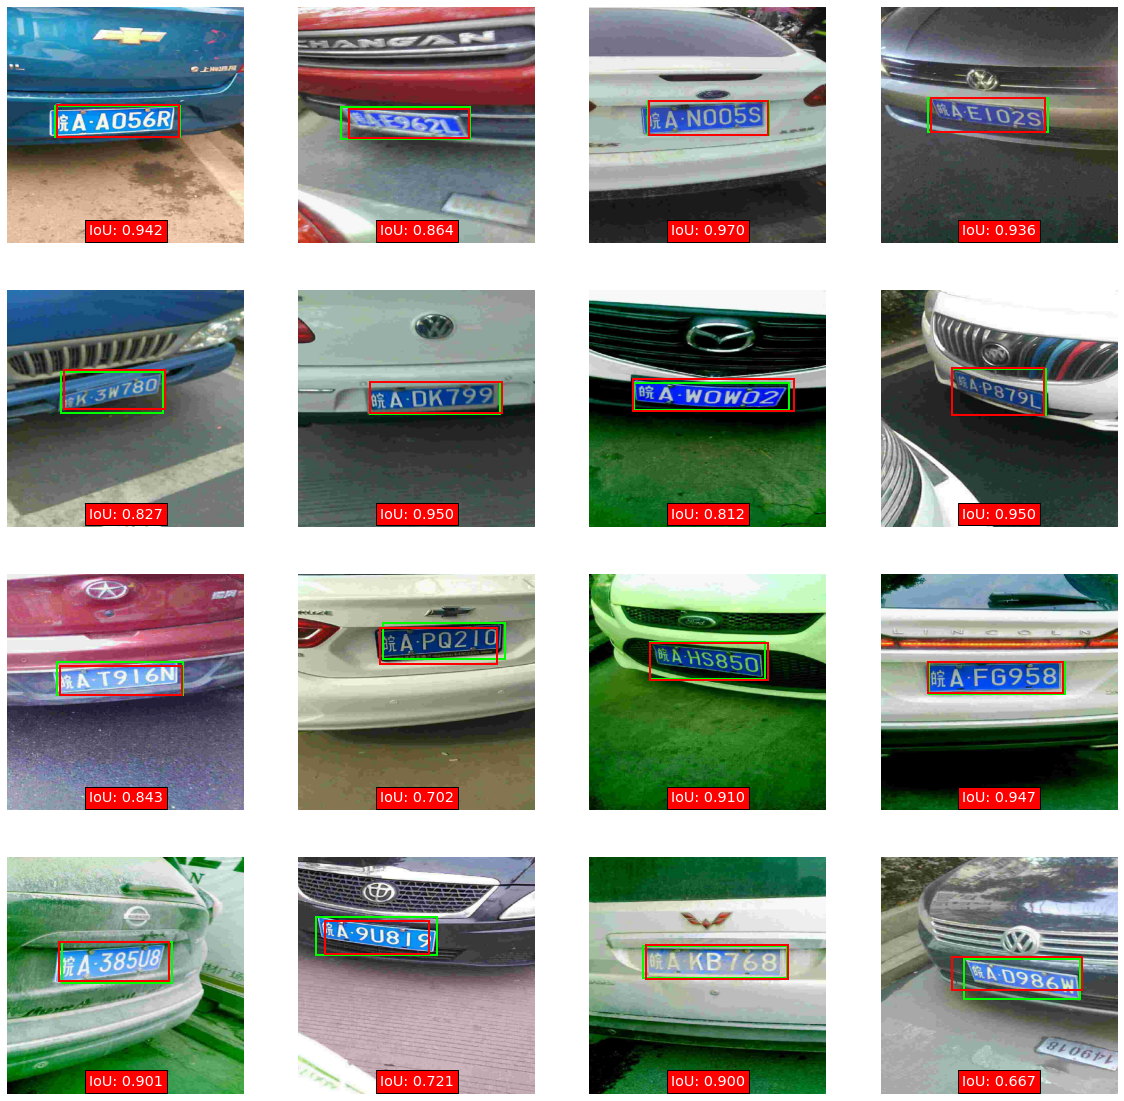

In [19]:
cols = 4
rows = round(num_samples / cols)
fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))

count = 0
for i in range(rows):
    for j in range(cols):
        index = si + count
        y_test_gt = get_bbox(y_test_boxes[index]) # de-normalise
        y_pred = get_bbox(y_preds[index])

        img = image.array_to_img(X_test[index])
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

        # ground truth coordinates
        xmin_gt, ymin_gt, xmax_gt, ymax_gt = y_test_gt
        width_gt = xmax_gt - xmin_gt
        height_gt = ymax_gt - ymin_gt

        # predicted coordinates
        xmin_p, ymin_p, xmax_p, ymax_p = y_pred
        width_p = xmax_p - xmin_p
        height_p = ymax_p - ymin_p

        # draw bounding boxes; lime = ground truth, red = predicted
        rect_gt = patches.Rectangle((xmin_gt, ymin_gt), width_gt, height_gt, linewidth=2, edgecolor="lime", facecolor="none")
        rect_p = patches.Rectangle((xmin_p, ymin_p), width_p, height_p, linewidth=2, edgecolor="red", facecolor="none")
        ax[i, j].add_patch(rect_gt)
        ax[i, j].add_patch(rect_p)

        # draw IoU label
        iou = get_iou(y_test_gt, y_pred)
        label = "IoU: {:.3f}".format(iou)
        ax[i, j].text(256, 500, label, size='x-large', color='white', ha="center", va="bottom", 
                      bbox={'facecolor': "red", 'alpha': 1.0})

        count += 1

plt.show()

In [0]:
# clear model
# keras.backend.clear_session()
# del model